In [53]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import math


# offsets of each variable in the mean state matrix
state_Dx, state_Dy, state_theta = 0,1,2
num_states = max(state_Dx, state_Dy, state_theta) + 1

class EKF:
    """
    Implementation of the Linear Kalman filter.
    """
    def __init__(self, initial_x, 
                       initial_v,
                       initial_theta,
                       accel_variance) -> None:
        
        """
        Initializes the mean state and covariance matrix of the state Gaussian random variable (GRV).
        
        Args:
            initial_x (list): The initial position of the system as a list of [x, y] coordinates.
            initial_v (list): The initial velocity of the system as a list of [vx, vy] coordinates.
            accel_variance (float): The variance of the acceleration noise.
        """
        
        # mean state matrix of Gaussian Random Variable (GRV)
        # initialized as 3x1 matrix
        self._x = np.zeros(num_states).reshape(num_states,1) 
        #self._x[state_Dx] = initial_x[0] + initial_v*math.cos(initial_theta)
        #self._x[state_Dy] = initial_x[1] + initial_v*math.sin(initial_theta)
        self._x[state_Dx] = initial_x[0]
        self._x[state_Dy] = initial_x[1]
        self._x[state_theta] = initial_theta
        #self._x[state_Vy] = initial_v[1]
        self._vel = initial_v
        
        # noise input matrix
        # initialized as 2x2 matrix
        self._accel_variance = np.eye(3) * accel_variance
        self._accel_variance[2,2] = self._accel_variance[2,2]/1000
        

        # covariance of state Gaussian Random Variable (GRV)
        # initialized as # 3x3 identity matrix
        self._P = np.eye(num_states)  
        

    def predict(self, dt: float) -> None:
        """
        Predict the state of the object after a time interval of dt seconds.
        
        Parameters
        ----------
        dt : float
            The time interval in seconds.
            
        Returns
        -------
        None
        
        
        Equations related to prediction Step
        x = F x
        P = F P Ft + G a Gt
        """
        def f_of_F(self,dt:float):
            self._x[state_Dx] = self._x[0] + self._vel * math.cos(self._x[2])
            self._x[state_Dy] = self._x[1] + self._vel * math.sin(self._x[2])
            self._x[state_theta] = self._x[2]
            
            return self._x
            
        
        # 3x3 state transition function
        F = np.array([[1, 0, math.sin(self._x[2])*dt],
                  [0, 1, math.cos(self._x[2])*dt],
                  [0, 0, 1]])

        # 3x1 mean state matrix at time t
        # x = F x --> new state as per the state transition matrix
        # predicted_x = self._x + F.dot(self._x)
        
        # x = f(x,u)
        predicted_x = f_of_F(self,dt)
        
        
        '''
        # 4x2 control matrix
        G = np.zeros((3,2)) 
        G[state_Dx,state_Dx] =G[state_Dy,state_Dy] = dt**2/2
        G[state_Vx,state_Dx]= G[state_Vy,state_Dy] = dt
        '''
        # 4x2 control matrix
        G = np.eye(3) 

        # 4x4 state covariance matrix at time t
        predicted_P = F.dot(self._P).dot(F.T) + G.dot(self._accel_variance).dot(G.T)

        self._P = predicted_P
        self._x = predicted_x

    def update(self, meas_value, meas_variance):
        """
        Update the state of the object after a time interval of dt seconds when measurements are received.
        
        Parameters
        ----------
        meas_value : array
            The actual measurement at a given time.
        meas_variance : array 
            The covariance matrix of the measurement noise.
        
        Returns
        -------
        None
        
        Equations related to update Step
        y = z - h(xt_pred)
        S = H P Ht + R
        K = P Ht S^-1
        x = x + K y
        P = (I - K H) * P
        """
        
        def f_of_H(self):
            obs_pred = np.vstack((self._x[0] + 0*self._vel* math.cos(self._x[2]),
                                self._x[1] - 1*self._vel* math.sin(self._x[2]),
                                 self._x[0] - 0.8*self._vel* math.cos(self._x[2]),
                                self._x[1] + 0.8*self._vel* math.sin(self._x[2]),
                                  self._x[0] + 0.8*self._vel* math.cos(self._x[2]),
                                self._x[1] + 0.8*self._vel* math.sin(self._x[2])))
            return obs_pred
        
        # 6x3 state observation matrix 
        # H = np.concatenate((np.eye(2),np.zeros((2,2))),axis=1)
        H = np.array([[1, 0, 0*math.sin(self._x[2])],
                  [0, 1, -1*math.cos(self._x[2])],
                  [1, 0, +0.8*math.sin(self._x[2])],
                  [0, 1, 0.8*math.cos(self._x[2])],
                  [1, 0, -0.8*math.sin(self._x[2])],
                  [0, 1, 0.8*math.cos(self._x[2])]])

        # 6x1 measurement matrix at time t ([[mDx1],[mDy1],[mDx2],[mDy2],[mDx3],[mDy3]])
        z = meas_value 
        
        # 6x6 measurement noise covariance matrix ([[sigma_x^2, 0], [0, sigma_y^2]])
        R = meas_variance

        # 6x1 innovation i.e (difference between the actual measurement z and the predicted measurement Hx)
        #y = z - H.dot(self._x)  # y = z - h(predicted_x)
        y = z - f_of_H(self)
        
        #print(z)
        #print(f_of_H(self))
        
        # 6x6 innovation covariance matrix (a measure of the error between the predicted measurement and the actual measurement)
        S = H.dot(self._P).dot(H.T) + R
        
        # 4x1 Kalman Gain Matrix 
        K = self._P.dot(H.T).dot(np.linalg.inv(S))

        # 4x1 updated state matrix after measurement at time t
        updated_x = self._x + K.dot(y)
        
        # 4x4 updated state covariance matrix after measurement at time t
        updated_P = (np.eye(3) - K.dot(H)).dot(self._P)

        self._x = updated_x
        self._P = updated_P
        
        #print(K)
        

    @property
    def cov(self) -> np.array:
        return self._P

    @property
    def mean(self) -> np.array:
        return self._x

    @property
    def pos(self) -> float:
        return self._x[iX]

    @property
    def vel(self) -> float:
        return self._x[iV]
    

C:\Users\Z0168020\AppData\Local\Temp\ipykernel_14716\3878928162.py:117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  input_velocity_over_total_time_steps = np.array(input_velocity_over_total_time_steps)
C:\Users\Z0168020\AppData\Local\Temp\ipykernel_14716\3878928162.py:118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  theta_over_total_time_steps = np.array(theta_over_total_time_steps)


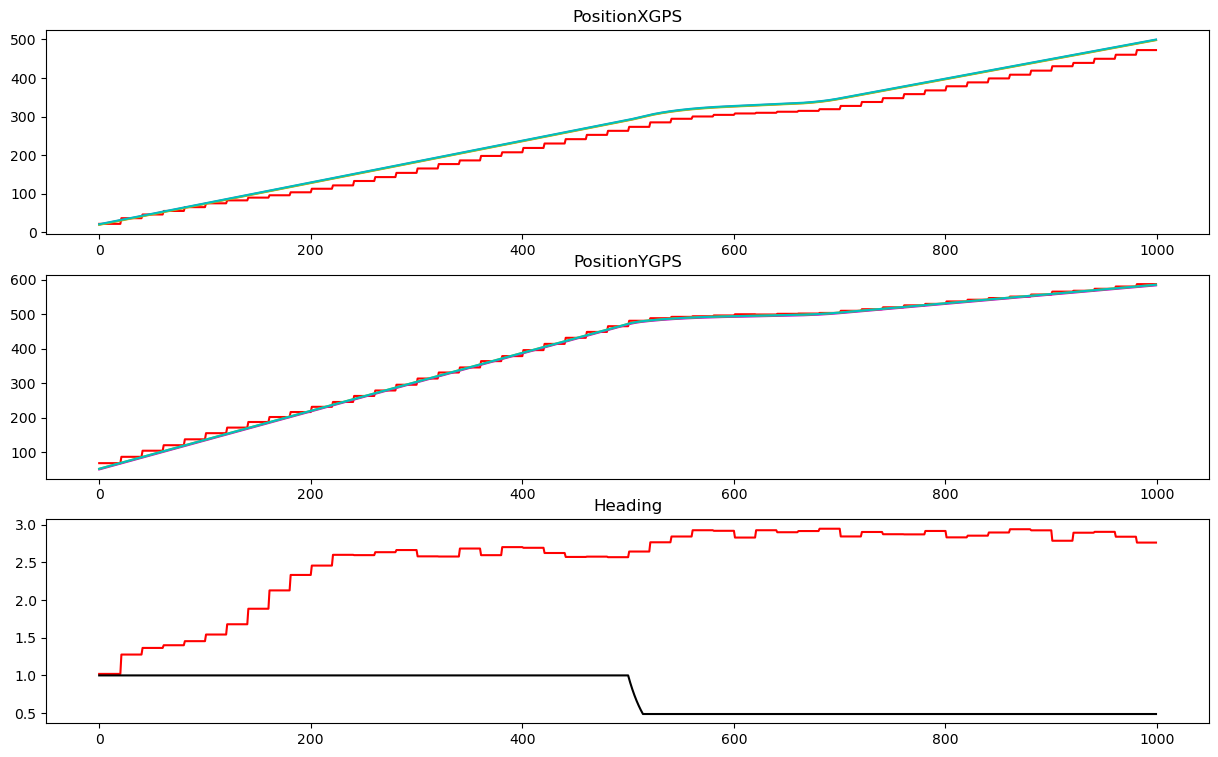

In [54]:
plt.ion()
plt.figure(figsize=(15,9))

# defining the initial true mean state of a system at time t=0
true_mean_state_vehicle_center = np.array([[20],[50]])
# gps measurement at time t
true_mean_state_gps1 = np.array([[0],[-1]]) + true_mean_state_vehicle_center
true_mean_state_gps2 = np.array([[-0.8],[0.8]]) + true_mean_state_vehicle_center
true_mean_state_gps3 = np.array([[0.8],[0.8]]) + true_mean_state_vehicle_center
true_theta_dot = 0

# gps measurements over entire total_time_steps
true_mean_state_over_total_time_steps_vehicle_center = []
true_mean_state_over_total_time_steps_gps1 = []
true_mean_state_over_total_time_steps_gps2 = []                                           
true_mean_state_over_total_time_steps_gps3 = []
input_velocity_over_total_time_steps = []
theta_over_total_time_steps = []

# minimum time step (dt) used in the simulation
time_steps = 1
# total number of time steps for which simulation will run
total_time_steps = 1000
 # time step at which measurement is received
measurement_rate = 20
# time step at which measurement update is done
        #measurement_time_steps = np.zeros([(total_time_steps-1)//measurement_rate,1])
measurement_time_steps = []

# sensor measurement variance matrix
sigma_measurement = 0.2
measurement_variance = np.eye(6)* sigma_measurement

# Velocity matrix used for creating a path based on initial true mean state
input_velocity = np.array([1])
# Heading matrix used for creating a path based on initial true mean state
input_heading = np.array([1])

# initialize the class KF with constructor parameters
kalman_filter_1 = EKF(initial_x=np.array([[11.5],[50.5]]), initial_v=np.array([0.98]), initial_theta = np.array([1.02]),
                     accel_variance=0.5)



mean_state_estimate_1 = []  #property of kalman_filter class
mean_state_estimate_error_1 = [] #property of kalman_filter class

mean_state_after_prediction = []
mean_state_after_gps_update = []

for step in range(total_time_steps):
    if step > 500 and step < 600:
        input_velocity = (np.array([0.98])).dot(input_velocity)
        if step < 515:
            input_heading = (np.array([0.95])).dot(input_heading)
    if step > 650 and step < 700:
        input_velocity = (np.array([1.03])).dot(input_velocity)

    mean_state_estimate_1.append(kalman_filter_1.mean)      
    mean_state_estimate_error_1.append(kalman_filter_1.cov)

    '''
    True mean position of the vehicle after minimum simulation time step. To calculate this 
    input velocity times the minimum time step is added to the previous true mean state.
    ---------------
    new position = old position + input velocity * simulation time step
    this is equivalent to 
    i = i + 2
    ---------------
    To simulate real-world conditions, random Gaussian noise is added to this position 
    to generate artificial position. This generated position is treated as sensor measurements.
    '''
    '''true_mean_state_vehicle_center = true_mean_state_vehicle_center + time_steps * input_velocity * np.array([[math.cos(kalman_filter_1.mean[2])]])
    true_mean_state_gps1 = true_mean_state_gps1 + time_steps * input_velocity * np.array([[math.cos(kalman_filter_1.mean[2])]])
    true_mean_state_gps2 = true_mean_state_gps2 + time_steps * input_velocity * np.array([[math.cos(kalman_filter_1.mean[2])]])
    true_mean_state_gps3 = true_mean_state_gps3 + time_steps * input_velocity * np.array([[math.cos(kalman_filter_1.mean[2])]])'''

    true_mean_state_vehicle_center = true_mean_state_vehicle_center + time_steps * input_velocity * np.array([[math.cos(input_heading)],[math.sin(input_heading)]])
    true_mean_state_gps1 = true_mean_state_gps1 + time_steps * input_velocity * np.array([[math.cos(input_heading)],[math.sin(input_heading)]])
    true_mean_state_gps2 = true_mean_state_gps2 + time_steps * input_velocity * np.array([[math.cos(input_heading)],[math.sin(input_heading)]])
    true_mean_state_gps3 = true_mean_state_gps3 + time_steps * input_velocity * np.array([[math.cos(input_heading)],[math.sin(input_heading)]])
    
    kalman_filter_1.predict(dt=time_steps)
    mean_state_after_prediction.append(kalman_filter_1.mean)

    if step != 0 and step % measurement_rate == 0:
        # print(step)
        
        ''' 
        Update by adding the random Gaussian noise into the true mean position
        '''
        measurement_time_steps.append(step)

        mgps1 = (true_mean_state_gps1 + np.random.randn() * np.sqrt(sigma_measurement))
        mgps2 = (true_mean_state_gps2 + np.random.randn() * np.sqrt(sigma_measurement))
        mgps3 = (true_mean_state_gps3 + np.random.randn() * np.sqrt(sigma_measurement))

        measurement_update = np.vstack((mgps1,mgps2,mgps3))

        kalman_filter_1.update(meas_value=measurement_update, meas_variance=measurement_variance)
        mean_state_after_gps_update.append(kalman_filter_1.mean)

    # Appending the variable value into list which store data for entire time horizon
    true_mean_state_over_total_time_steps_vehicle_center.append(true_mean_state_vehicle_center)
    true_mean_state_over_total_time_steps_gps1.append(true_mean_state_gps1)
    true_mean_state_over_total_time_steps_gps2.append(true_mean_state_gps2)
    true_mean_state_over_total_time_steps_gps3.append(true_mean_state_gps3)
    input_velocity_over_total_time_steps.append(input_velocity)
    theta_over_total_time_steps.append(input_heading)
    

 # since the data stored in the variable in a list format we have to convert it into array for easy plotting
true_mean_state_over_total_time_steps_vehicle_center = np.array(true_mean_state_over_total_time_steps_vehicle_center)
true_mean_state_over_total_time_steps_gps1 = np.array(true_mean_state_over_total_time_steps_gps1)
true_mean_state_over_total_time_steps_gps2 = np.array(true_mean_state_over_total_time_steps_gps2)
true_mean_state_over_total_time_steps_gps3 = np.array(true_mean_state_over_total_time_steps_gps3)
input_velocity_over_total_time_steps = np.array(input_velocity_over_total_time_steps)
theta_over_total_time_steps = np.array(theta_over_total_time_steps)



plt.subplot(3, 1, 1)
plt.title('PositionXGPS')
plt.plot([ms[0] for ms in mean_state_estimate_1], 'r') # ms[0] has x position estimates
plt.plot(true_mean_state_over_total_time_steps_gps1[:,0], 'm') 
plt.plot(true_mean_state_over_total_time_steps_gps2[:,0], 'y')
plt.plot(true_mean_state_over_total_time_steps_gps3[:,0], 'c')
#plt.plot([mu[0] - 2*np.sqrt(cov[0,0]) for mu, cov in zip(mus,covs)], 'r--') #lower limit of estimate
#plt.plot([mu[0] + 2*np.sqrt(cov[0,0]) for mu, cov in zip(mus,covs)], 'r--') #upper limit of estimate

plt.subplot(3, 1, 2)
plt.title('PositionYGPS')
plt.plot([ms[1] for ms in mean_state_estimate_1], 'r') # ms[1] has x position estimates
plt.plot(true_mean_state_over_total_time_steps_gps1[:,1], 'm')
plt.plot(true_mean_state_over_total_time_steps_gps2[:,1], 'y')
plt.plot(true_mean_state_over_total_time_steps_gps3[:,1], 'c')
#plt.plot([mu[1] - 2*np.sqrt(cov[1,1]) for mu, cov in zip(mus,covs)], 'r--') #lower limit of estimate
#plt.plot([mu[1] + 2*np.sqrt(cov[1,1]) for mu, cov in zip(mus,covs)], 'r--') #upper limit of estimate

plt.subplot(3, 1, 3)
plt.title('Heading')
plt.plot([ms[2] for ms in mean_state_estimate_1], 'r')  # ms[2] has theta estimates
plt.plot(theta_over_total_time_steps[:], 'k')
#plt.plot([mu[2] - 2*np.sqrt(cov[2,2]) for mu, cov in zip(mus,covs)], 'r--') #lower limit of estimate
#plt.plot([mu[2] + 2*np.sqrt(cov[2,2]) for mu, cov in zip(mus,covs)], 'r--') #upper limit of estimate

In [38]:
np.zeros([3,2])

array([[0., 0.],
       [0., 0.],
       [0., 0.]])